In [1]:
import os
import pandas as pd
import cv2 as cv
import PIL.Image as Image
import numpy as np  

In [3]:
train_path = "../Data/train/"
test_path = "../Data/test/"

train_label = dict()
for i,folder in enumerate(os.listdir(train_path)):
    train_label[i]=folder
print(train_label)


{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


In [15]:
imagelists = []
for i in range(12):
    fathername = os.path.join(train_path,train_label[i])
    imagelist = []
    imagename = [filename for filename in os.listdir(fathername) if filename.endswith('png')]
    for filename in imagename:
        imagepath = os.path.join(fathername,filename)
        img  = Image.open(imagepath)
        imagelist.append(img)
    imagelists.append(imagelist)
lenofeach = []
for imglist in imagelists:
    lenofeach.append(len(imglist))
imagename = list(train_label.values())
imagelabel = list(train_label.keys())
print(lenofeach)
print(imagename)
print(imagelabel)

[248, 362, 268, 571, 203, 431, 613, 206, 486, 220, 461, 371]
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


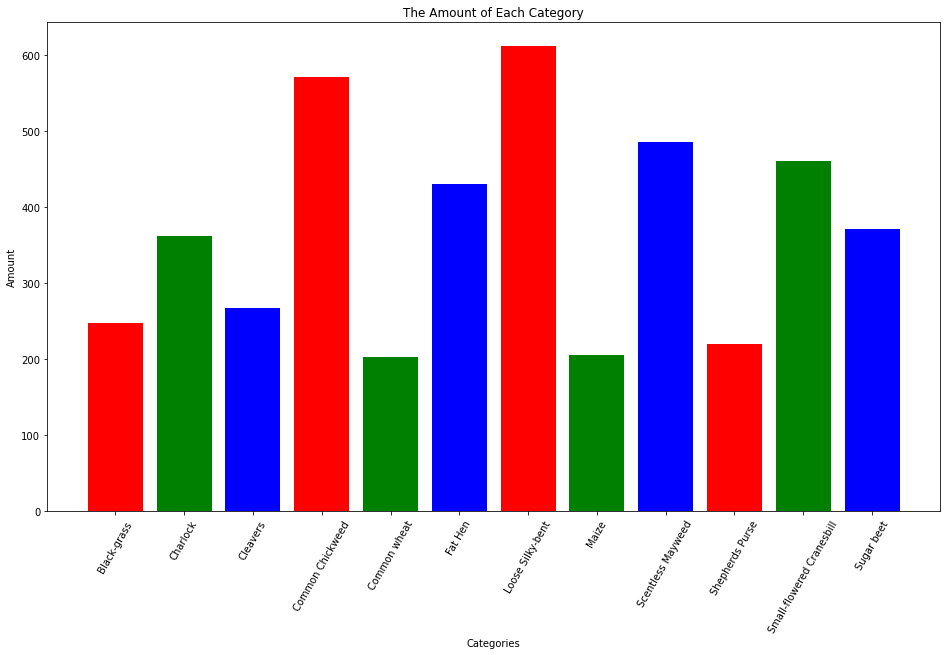

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,9))
plt.bar(imagename,lenofeach,color = ['r','g','b'])
plt.xlabel("Categories")
plt.ylabel("Amount")
plt.xticks(rotation  = 60)
plt.title("The Amount of Each Category")
plt.show()

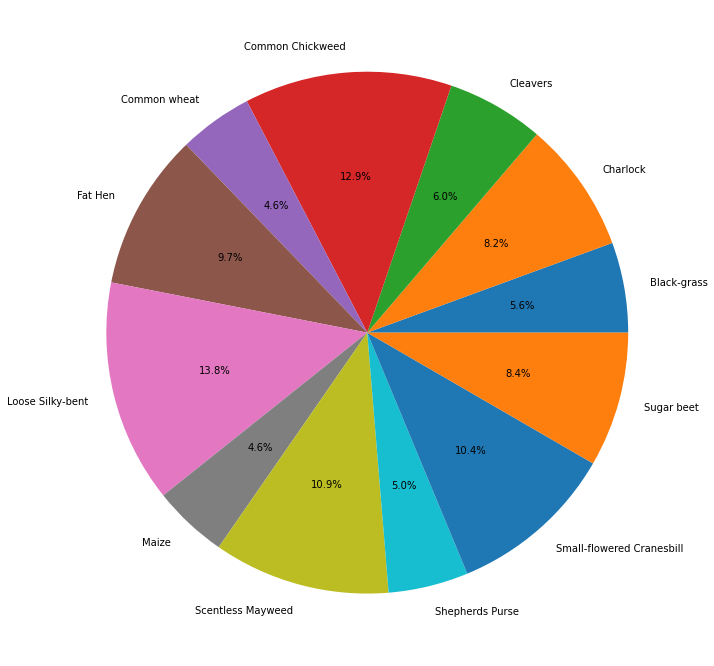

In [44]:
percentofeach = [percent*100/sum(lenofeach) for percent in lenofeach]
plt.figure(figsize = (16,12))
plt.pie(percentofeach , labels =imagename,autopct="%1.1f%%")
plt.show()

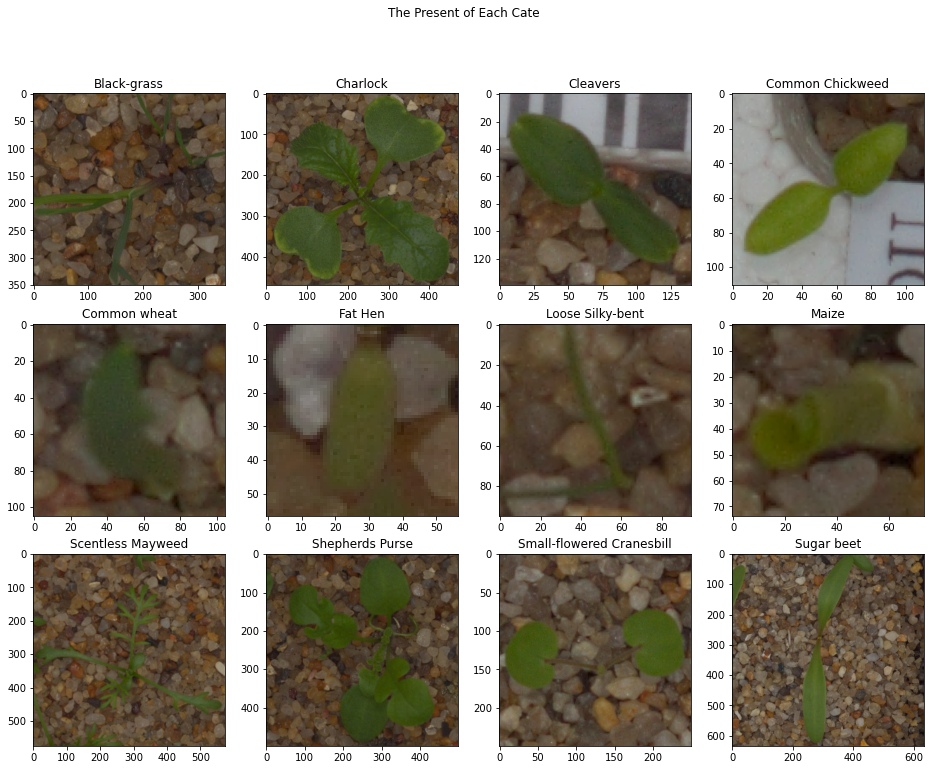

In [40]:
fig,axes = plt.subplots(3,4,figsize =(16,12))
for i in range(12):
    row = i//4
    col = i%4
    axes[row][col].imshow(imagelists[i][100])
    axes[row][col].set_title(imagename[i])
fig.suptitle("The Present of Each Cate")
plt.show()

*****
* 使用NearMiss方法对X_train进行降采样
* 将图片resize成224*224
* 将resize之后的图片转化成灰度图片：问题发现有一些图片并不是RGB格式,导致特征长度不一致
* 将数据标准化之后放进逻辑回归中训练
* 输出相关的分数
* 输出混淆矩阵热力图

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss


In [46]:
RANDOM_STATE = 42
labellists = []
for i,imagelist in enumerate(imagelists):
    labellist = [i for _ in range(len(imagelist))]
    labellists.append(labellist)

0 1


In [153]:
size = (224,224)
resizeimagelists = []
for imagelist in imagelists:
    resizeimagelist = []
    for image in imagelist:
        newimg = image.resize(size).convert('L')
        resizeimagelist.append(newimg)
    resizeimagelists.append(resizeimagelist)


In [154]:
resizeimagelists[0][0].size

(224, 224)

In [134]:
for sublist in resizeimagelists:
    for img in sublist:
        if img.size!=size:
            print("WRONG")

In [151]:
resizeimagelists[0][7].size

(224, 224)

In [155]:
np.array(resizeimagelists[0][7]).shape

(224, 224)

In [156]:
X = [[np.array(img).flatten() for img in resizeimagelist] for resizeimagelist in resizeimagelists]
y = [[np.array(i) for i in labellist]for labellist in labellists]

In [158]:
for idx,i in enumerate(X[0]):
    if len(i)!=224*224:
        print("WRONG",len(i),idx,type(i))

In [159]:
X_combined = [item for sublist in X for item in sublist]
y_combined = [item for sublist in y for item in sublist]

In [161]:
X_train,X_test,y_train,y_test = train_test_split(X_combined,y_combined,random_state=RANDOM_STATE,test_size=0.2,shuffle=True)

In [165]:
for idx,i in enumerate(X_train):
    if len(i)!=50176:
        print("WRONG",len(i),idx)

In [167]:
pipeline = make_pipeline(NearMiss(version=2), StandardScaler(), LogisticRegression())
pipeline.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('nearmiss', NearMiss(version=2)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [169]:
y_pred = pipeline.predict(X_test)

In [185]:
y_pred = list(y_pred)
y_test = [int(y) for y in y_test]

In [186]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.09      0.08      0.95      0.08      0.27      0.07        53
          1       0.10      0.08      0.93      0.09      0.27      0.07        76
          2       0.14      0.27      0.89      0.19      0.49      0.23        55
          3       0.19      0.14      0.90      0.16      0.36      0.12       121
          4       0.08      0.08      0.94      0.08      0.28      0.07        48
          5       0.11      0.11      0.91      0.11      0.32      0.09        80
          6       0.24      0.12      0.93      0.16      0.33      0.10       136
          7       0.06      0.14      0.91      0.08      0.35      0.11        37
          8       0.11      0.16      0.87      0.13      0.37      0.13        82
          9       0.09      0.21      0.89      0.13      0.44      0.18        42
         10       0.10      0.07      0.93      0.08      0.26      0.06        84
   

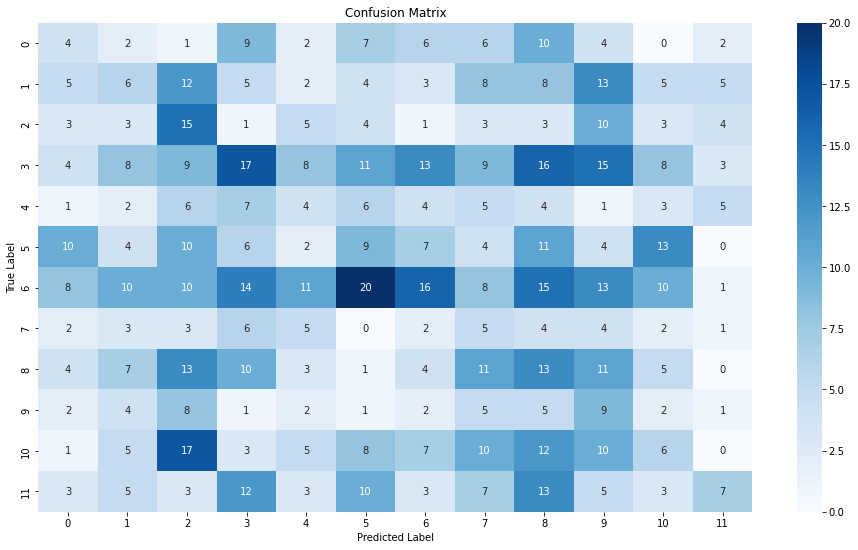

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16,9))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=imagelabel, yticklabels=imagelabel)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()